(400, 640)
V:
7.85827646186
7.90952926689
7.98707230247
7.96786903273
7.86237124503
7.97412921714
7.64548003527
7.83404573423
7.97129740689



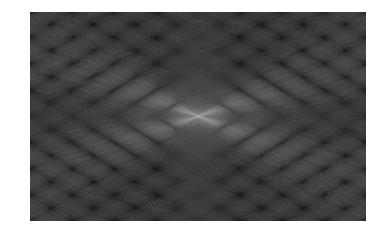

In [23]:
# for python 2 compatibility #
from __future__ import print_function
#                            #
import numpy as np
from skimage import io
from skimage.draw import polygon, circle
from skimage.transform import rotate
import matplotlib.pyplot as plt
import math
import matplotlib.patches as patches
import matplotlib as mpl
%matplotlib inline

letter_list = ['S', 'T', 'V']
k_number_of_images = 10
# get dummy image
avg_img = io.imread('S1.GIF')

# convert to np.array so that we can compute the average  
avg_img_array = np.array(avg_img, dtype=float)
print(avg_img_array.shape)


# 640 x 400 pixels
for letter in letter_list[2]:
    # reset np.array
    avg_img_array.fill(0)
    print(letter + ":")
    for image_index in range(1, k_number_of_images):
        image_name = letter + str(image_index) + '.GIF'
        f = io.imread(image_name)   # read in image

        f_f = np.array(f, dtype=float)
        z = np.fft.fft2(f_f)           # do fourier transform
        q = np.fft.fftshift(z)         # puts u=0,v=0 in the centre

        Magq =  np.absolute(q)         # magnitude spectrum
        log_Magq = np.log(Magq + 1)
        log_Magq_array = np.array(log_Magq, dtype=float)
        
        for idx, pixel in enumerate(log_Magq_array):
            avg_img_array[idx] += pixel
        
        
        Phaseq = np.angle(q)           # phase spectrum

        image_avg_pixel_val = np.mean(log_Magq)
        print(image_avg_pixel_val)
        
    avg_img_array /= k_number_of_images
    
    print()

fig1 = plt.figure()
ax1  = fig1.add_subplot( 111 )
ax1.axis('off')
# Usually for viewing purposes:b
ax1.imshow( avg_img_array, cmap='gray' ) # io.

# fig1 = plt.figure()
# ax1  = fig1.add_subplot( 111 )
# ax1.axis('off')
# Usually for viewing purposes:
# ax1.imshow( np.log( np.absolute(q) + 1 ), cmap='gray' ) # io.

# w = np.fft.ifft2( np.fft.ifftshift(q) ) # do inverse fourier transform
#
# fig2 = plt.figure()
# ax2  = fig2.add_subplot( 111 )
# ax2.axis('off')
# ax2.imshow( np.array(w,dtype=int), cmap='gray' ) # io.

plt.show()

In [2]:
def euclidean_distance(A, B):
    return math.sqrt( (A[0] - B[0])**2 + (A[1] - B[1])**2 )

400 640


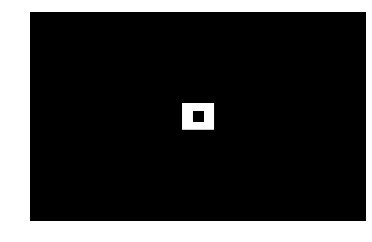

In [3]:
def box_filter( image_array, height, width, inner_height, inner_width ):
    filter_image_array = np.array(image_array, dtype=float)
    filter_image_array.fill(0)
    rows = image_array.shape[0]
    cols = image_array.shape[1]
    print(rows, cols)
    center = ( int(rows / 2), int(cols / 2) )
    top_left     = ( center[0] - int(height / 2), center[1] - int(width / 2) )
    bottom_right = ( center[0] + int(height / 2), center[1] + int(width / 2) )
    
    inner_top_left     = ( center[0] - int(inner_height / 2), center[1] - int(inner_width / 2) )
    inner_bottom_right = ( center[0] + int(inner_height / 2), center[1] + int(inner_width / 2) )

    for row in range(rows):
        if not (top_left[0] <= row and row <= bottom_right[0]):
            continue
        for col in range(cols):
            if top_left[1] <= col and col <= bottom_right[1]:
                if not (inner_top_left[1] <= col and col <= inner_bottom_right[1]) \
                    or (not (inner_top_left[0] <= row and row <= inner_bottom_right[0])):
                        filter_image_array[row][col] = True
                   
    fig1 = plt.figure()
    ax1  = fig1.add_subplot( 111 )
    ax1.axis('off')
    # Usually for viewing purposes:b
    ax1.imshow( filter_image_array, cmap='gray' ) # io.
    plt.show()
    

box_filter( avg_img_array, 50, 60, 20, 20 )

400 640
(200, 320)
134.536240471


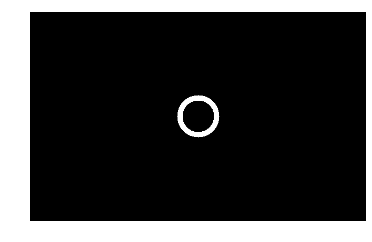

In [4]:
def ring_filter( image_array, radius_outter, radius_inner ):
    filter_image_array = np.array(image_array, dtype=float)
    filter_image_array.fill(0)
    rows = image_array.shape[0]
    cols = image_array.shape[1]
    print( rows, cols )
    center = ( int(rows / 2), int(cols / 2) )
    print( center )
    
    print(np.linalg.norm([100, 230] - np.asarray(center)))
    
    for row in range(rows):
        if not (center[0] - radius_outter <= row and row <= center[0] + radius_outter):
            continue
        for col in range(cols):
            if center[1] - radius_outter <= col and col <= center[1] + radius_outter:
                if np.linalg.norm([row, col] - np.asarray(center)) <= radius_outter:
                    if radius_inner <= np.linalg.norm([row, col] - np.asarray(center)):
                        filter_image_array[row][col] = True

    fig1 = plt.figure()
    ax1  = fig1.add_subplot( 111 )
    ax1.axis('off')
    # Usually for viewing purposes:b
    ax1.imshow( filter_image_array, cmap='gray' ) # io.
    plt.show()
    
ring_filter( avg_img_array, 40, 30 )

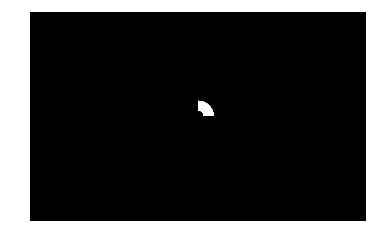

In [5]:
'''
Returns a grayscale image representing a sector filter.

Parameters
----------
    radius  : radius of the sector. 

    theta_1 : the angle between the Ox axis and the right side of the sector.
    
    theta_2 : the angle between the Ox axis and the left side of the sector.
'''
def sector_filter( image_array, radius, theta_1, theta_2, inner_circle_radius=0):
    filter_image_array = np.array(image_array, dtype=float)
    filter_image_array.fill(0)
    rows = image_array.shape[0]
    cols = image_array.shape[1]
    
    center = ( int(rows / 2), int(cols / 2) )
    
    for row in range(rows):
        # Flip the graph by the Ox axis.
        translated_row = -(row - center[0])
        # To avoid division by zero in the computation of atan below.
        if translated_row == 0 or translated_row < 0:
            continue
        for col in range(cols):
            translated_col = col - center[1]
            if (translated_row)**2 + (translated_col)**2 > radius**2:
                continue
            # Inner circle
            dist = euclidean_distance((0, 0), (translated_row, translated_col))
            if dist <= inner_circle_radius:
                continue
            arctg_degrees = math.degrees(math.atan( translated_col / translated_row ) )
            if theta_1 <= arctg_degrees and arctg_degrees <= theta_2:
                # Mark the original, untranslated pixel.
                filter_image_array[row][col] = True
                
    fig1 = plt.figure()
    ax1  = fig1.add_subplot( 111 )
    ax1.axis('off')
    # Usually for viewing purposes:b
    ax1.imshow( filter_image_array, cmap='gray' ) # io.
    plt.show()
    
sector_filter( avg_img_array, 30, 0, 120, 10 )

In [97]:
def draw_rekt(bottom_left, w, h, r):
    img = np.zeros((400, 640), dtype=float)

    rows = img.shape[0]
    cols = img.shape[1]
    print(rows, cols)
    center = ( int(cols / 2), int(rows / 2) )
    top_left = (bottom_left[0] - h, bottom_left[1])
    bottom_right = (bottom_left[0], bottom_left[1] + w)
    top_right = (top_left[0], top_left[1] + w)
    
    X = [top_left[0],  top_right[0],  bottom_right[0], bottom_left[0]]
    Y = [top_left[1],  top_right[1],  bottom_right[1], bottom_left[1]]
    
    x = np.array(X)
    y = np.array(Y)
    rr, cc = polygon(x, y)
    img[rr, cc] = 1
    img = rotate(img, r, center=center, preserve_range=True)
    return img


400 640
400 640
400 640
400 640
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


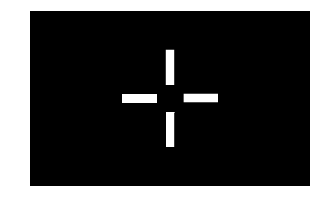

In [100]:
fig1 = plt.figure(figsize=(5, 8), dpi=80)
ax1  = fig1.add_subplot( 111 )
ax1.axis('off')


rekt_bottom_left = (170, 310)
hands = []
curr_hand = draw_rekt(rekt_bottom_left, 20, 80, 0)
hands.append(curr_hand)
curr_hand = draw_rekt(rekt_bottom_left, 20, 80, 90)
hands.append(curr_hand)
curr_hand = draw_rekt(rekt_bottom_left, 20, 80, 180)
hands.append(curr_hand)
curr_hand = draw_rekt(rekt_bottom_left, 20, 80, 270)
hands.append(curr_hand)

result_img = np.array(avg_img_array, dtype=float)
result_img.fill(0)
for row in range(result_img.shape[0]):
    for col in range(result_img.shape[1]):
        for hand in hands:
            if hand[row][col] == True:
                result_img[row][col] = True
# test_img = cross((180, 300), 40, 80, 90)
print(result_img)
ax1.imshow( result_img, cmap='gray' ) # io.
plt.savefig('plus-filter.png')
plt.show()

400 640
400 640
400 640
400 640
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


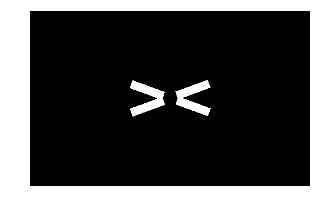

In [109]:
fig1 = plt.figure(figsize=(5, 8), dpi=80)
ax1  = fig1.add_subplot( 111 )
ax1.axis('off')


rekt_bottom_left = (185, 310)
hands = []
curr_hand = draw_rekt(rekt_bottom_left, 20, 80, 70)
hands.append(curr_hand)
curr_hand = draw_rekt(rekt_bottom_left, 20, 80, 110)
hands.append(curr_hand)
curr_hand = draw_rekt(rekt_bottom_left, 20, 80, 250)
hands.append(curr_hand)
curr_hand = draw_rekt(rekt_bottom_left, 20, 80, 290)
hands.append(curr_hand)

result_img = np.array(avg_img_array, dtype=float)
result_img.fill(0)
for row in range(result_img.shape[0]):
    for col in range(result_img.shape[1]):
        for hand in hands:
            if hand[row][col] == True:
                result_img[row][col] = True
# test_img = cross((180, 300), 40, 80, 90)
print(result_img)
ax1.imshow( result_img, cmap='gray' ) # io.
plt.savefig('cross-filter.png')
plt.show()